In [29]:
import pandas as pd
import numpy as np
import re
import os

import html2text
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import yfinance as yf
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import string
from collections import Counter

In [30]:
cur_path = os.getcwd()

In [31]:
test_path = os.path.abspath('.\\datasets\\RAW_FILINGS')
#test_path

In [4]:
test_list = os.listdir(test_path)
#test_list

In [5]:
file_list2 = [str(test_path)+"\\"+file for file in test_list]
#file_list2

In [6]:
# Item 2.  Management’s Discussion and Analysis of Financial Condition and Results of Operations
def MDA(file_name):
    with open(file_name, 'r') as f:
        html_string = f.read()

        s = html2text.html2text(html_string)
        
        s = s.translate(str.maketrans('', '', string.punctuation))
        
        #print(s)
        
        s_re = s.replace("-"," ")
        s_re = s_re.replace("|","")
        s_re = s_re.replace("*","")
        s_re = s_re.replace("•","")
        s_re = s_re.replace("◦","")
        txt = s_re.split("\n")
        
        #print(txt[::-1])
        
        tmp_txt = []
        flag = 0

        for line in txt[::-1]:
            
            line = line.strip()

            if flag == 1:
                line = line.strip()
                if line == "":
                    continue
                # filter double 
                if re.match(r"^[-+]?([0-9]*\.[0-9]+|[0-9]+)$",line):
                    continue
                if re.match(r"^[-+]?([0-9]*\,[0-9]+|[0-9]+)$",line):
                    continue
                if line.strip() in ["$","%","(",")"]:
                    continue
                if re.match(r"^[(]?[-+]?([0-9]*[\,]*[0-9]*\.[0-9]+|[0-9]+)[)]?$",line):
                    continue
                tmp_txt.append(line)

            #if re.match(r".*Item 2. Management's Discussion and Analysis",line,re.IGNORECASE):
            if re.match(r"^Item.*Management.*s.*Discussion.*and.*Analysis",line,re.IGNORECASE) or re.match(r"^Item.*Management.*s.*Discussion.*and.*Analysis",line,re.IGNORECASE):
                #print("Finish")
                flag = 2
                break
            #if re.match(r".*Item 3. Quantitative and Qualitative Disclosures",line,re.IGNORECASE):
            if re.match(r"^Item.*Quantitative.*and.*Qualitative.*Disclosures",line,re.IGNORECASE) or re.match(r"^Quantitative.*and.*Qualitative.*Disclosures",line,re.IGNORECASE):
                #print("Start")
                flag = 1
        
        if flag == 0:
            return (tmp_txt[::-1], "failure")
        elif flag == 1:
            return (tmp_txt[::-1], "tentative")            
        else:
            return (tmp_txt[::-1], "complete") 
        


In [7]:
neg_words = pd.read_csv("negdic.csv")
# neg_words

In [8]:
stopword_list = stopwords.words('english')

In [9]:
h4n = list(neg_words["H4N"].str.lower())
fn = list(neg_words["Fin_Neg"].str.lower())

In [10]:
def clean_tokenize_fullist(line, stopword_list, processed_list):
    line = line.translate(str.maketrans('', '', string.punctuation)) # Remove punctiations
    word_list = list(filter(lambda x: x not in stopword_list and x != '' and x.isalpha(), re.split(r'\W+', line.lower())))
    
    processed_list += word_list
    return processed_list

In [11]:
def nlp_scores_tfidf(file_name):
    
    #print(file_name)
    content = MDA(file_name)
    
    report = content[0]
    scan_status = content[1]
    
    processed_list = []
    for line in report:
        clean_tokenize_fullist(line, stopword_list, processed_list)
    
    if len(processed_list) == 0:
        return (0,0,0,"failure")
    else:
        dict_word_freq = Counter(processed_list)
        h4n_neg_dict = {K: V for K, V in dict_word_freq.items() if K in h4n}
        fn_neg_dict = {K: V for K, V in dict_word_freq.items() if K in fn}
        
        avg_word_freq = sum(dict_word_freq.values())/len(dict_word_freq.values())
        
        for h4n_K in h4n_idf_count.keys():
            if h4n_K in processed_list:
                h4n_idf_count[h4n_K] += 1
            
        for fn_K in fn_idf_count.keys():
            if fn_K in processed_list:
                fn_idf_count[fn_K] += 1
            
        if scan_status == "complete":
            return (h4n_neg_dict, fn_neg_dict, avg_word_freq, "success")
        else:
            return (h4n_neg_dict, fn_neg_dict, avg_word_freq, "tentative")

In [12]:
sp_500_return = pd.read_csv("s&p500_ret.csv")
sp_500_return["date"] = sp_500_return["date"].apply(lambda x:datetime.strptime(x,"%m/%d/%y"))
sp_500_return.set_index("date",inplace = True)
sp_500_return_ts = sp_500_return["vw_ret_d"]

filing_df = pd.read_csv(cur_path+"/datasets/FILINGS_METADATA.csv")
cik_df = pd.read_csv("sp500_w_addl_id_with_cik.csv")

cik_df = cik_df.iloc[: , 1:]
cik_df["cik"] = cik_df["cik"].values.astype(int).astype(str)
cik_df["date"] = cik_df["date"].apply(lambda x:datetime.strptime(x,"%m/%d/%y"))
cik_df = cik_df[cik_df["date"] >= "1/1/2016"]
cik_df.sort_values(by=['cik', 'date'],inplace = True)

filing_df["CIK"] = filing_df["CIK"].values.astype(int).astype(str)

C:\Users\bruce\AppData\Local\Temp\ipykernel_11300\3914721342.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cik_df = pd.read_csv("sp500_w_addl_id_with_cik.csv")


In [13]:
cik_df

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,cik,sic,naics,gind,gsubind
41427,2016-01-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,-0.069614,1000180,3572,334112,452020,45202030
41428,2016-02-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,0.022065,1000180,3572,334112,452020,45202030
41429,2016-03-31,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,0.052865,1000180,3572,334112,452020,45202030
41430,2016-04-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,-0.012487,1000180,3572,334112,452020,45202030
41441,2016-01-29,82581,SCHEIN HENRY INC,80640710,11,3,5047,HSIC,61494,1,3/18/15,3/31/22,-0.042670,1000228,5047,423450,351020,35102010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,2017-07-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.015026,9892,3841,339112,351010,35101010
2365,2017-08-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.000655,9892,3841,339112,351010,35101010
2366,2017-09-29,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,-0.000966,9892,3841,339112,351010,35101010
2367,2017-10-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.020499,9892,3841,339112,351010,35101010


# get the price

In [14]:
ciks = set(cik_df["cik"].values)
tickers = set()

old_ticker = {
    'MYL':'VTRS',
    'BBT':'TFC',
    'ARNC':'HWM',
    'PCLN':'BKNG',
    'COG':'CTRA',
    'CTL':'LUMN',
    'MHFI':'SPGI',
    'CBS':'VIAC',
    'TMK':'GL',
    'KORS':'CPRI',
    'GMCR':'DPS',
    'TSO':'ANDV',
    'HRS':'LHX',
    'UTX':'RTX',
    'CBG':'CBRE',
    'SYMC':'NLOK',
    'LB':'BBWI',
    'UA':'UAA',
    'Q':'IQV',
    'DOW':'DD',
    'DWDP':'DD',
    'DLPH':'APTV',
    'BHGE':'BKR',
    'JEC':'J',
    'IR':'TT',
    'PX':'LIN',
    'HCP':'PEAK',
    'LUK':'JEF',
    'COH':'TPR',
}

for tmp_cik in ciks:
    tmp_tickers = set(cik_df[cik_df["cik"] == tmp_cik]["ticker"].values)
    if len(tmp_tickers) == 1:
        ticker = tmp_tickers.pop()
    elif len(tmp_tickers) == 2:
        ticker = tmp_tickers.pop()
        if ticker in old_ticker.keys():
            ticker = old_ticker[ticker]
    tickers.add(ticker)
    
tickers = list(tickers)

price_df = yf.download(tickers, start = "2016-01-01", end = "2021-12-31", group_by='ticker')

index = [(i,"Adj Close") for i in tickers]
price_df = price_df[index]
price_df.columns = price_df.columns.get_level_values(0)

[*********************100%***********************]  631 of 631 completed

60 Failed downloads:
- STJ: No data found for this date range, symbol may be delisted
- WFM: No data found for this date range, symbol may be delisted
- PBCT: No data found, symbol may be delisted
- TE: No data found for this date range, symbol may be delisted
- FLIR: No data found, symbol may be delisted
- XEC: No data found, symbol may be delisted
- CXO: No data found, symbol may be delisted
- NBL: No data found, symbol may be delisted
- SPLS: No data found for this date range, symbol may be delisted
- BCR: No data found for this date range, symbol may be delisted
- CAM: No data found for this date range, symbol may be delisted
- BXLT: No data found for this date range, symbol may be delisted
- MJN: No data found for this date range, symbol may be delisted
- APC: No data found, symbol may be delisted
- LLTC: No data found for this date range, symbol may be delisted
- CVC: No data found for this date range, symb

In [15]:
df = pd.read_csv("sp500_w_addl_id_with_cik_16_21.csv", index_col=[0])
ffile = pd.read_csv(cur_path+"/datasets/FILINGS_METADATA.csv")

f_titles = ffile['filename'].values


#sp_ciks = [str(x) for x in set(df["cik"].values)]
sp_ciks = list(set(df["cik"].values))
n_comp = len(sp_ciks)
flag_first_report = pd.DataFrame(np.zeros([25,n_comp]),columns=sp_ciks)
flag_first_report  #It's a table records if a report has been processed or not


#Change the type of date in df to datetime
date_datetime = [datetime.strptime(x,"%m/%d/%Y").date() for x in df['date'].values]
df["date_datetime"] = date_datetime
time_adj = [datetime.strptime(x,"%m/%d/%Y").date() for x in set(df['date'].values)]
time_adj.sort()

C:\Users\bruce\AppData\Local\Temp\ipykernel_11300\1557415716.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sp500_w_addl_id_with_cik_16_21.csv", index_col=[0])


In [16]:
# calculate the excess return at the filing date

In [17]:
def check_file(f_title):
    date_str = ffile[ffile['filename']==f_title]['Date'].values[0]
    cik_str = ffile[ffile['filename']==f_title]['CIK'].values[0]
    report_str = ffile[ffile['filename']==f_title]['Period of Report'].values[0]

    file_t = datetime.strptime(date_str,"%m/%d/%Y").date()
    report_t = datetime.strptime(report_str,"%m/%d/%Y").date()
    cik = int(cik_str)
    i=0
    while(file_t > time_adj[i]):
        i += 1
    last_adj_date = time_adj[i-1]
    ciks = df[df["date_datetime"]==last_adj_date]['cik'].values
    if cik not in ciks:
        #print(str(cik)," is not in ciks")
        return False
    else:
        yy = report_t.year - 2016
        mm = (report_t.month - 1) // 3
        flag_i = yy*4 + mm + 1
        if flag_first_report.loc[flag_i, cik] != 0:
            #print("Not the first report for this report period", report_str)
            return False
        else:
            flag_first_report.loc[flag_i, cik] = 1
            #print("let's apply NLP to cik = ", cik_str, ", file with report period", report_str)
            return True
        
def info(f_title):
    date_str = ffile[ffile['filename']==f_title]['Date'].values[0]
    cik_str = str(ffile[ffile['filename']==f_title]['CIK'].values[0])
    report_str = ffile[ffile['filename']==f_title]['Period of Report'].values[0]
    filing_name_str = ffile[ffile['filename']==f_title]['filename'].values[0]
    file_t = datetime.strptime(date_str,"%m/%d/%Y").date()
    return [cik_str, file_t,filing_name_str]

In [18]:
ffile

,CIK,Company,Type,Date,complete_text_file_link,html_index,Filing Date,Period of Report,SIC,htm_file_link,State of Inc,State location,Fiscal Year End,filename
0,1000180,SANDISK CORP,10-K,2/12/2016,https://www.sec.gov/Archives/edgar/data/100018...,https://www.sec.gov/Archives/edgar/data/100018...,2/12/2016,1/3/2016,3572,https://www.sec.gov/Archives/edgar/data/100018...,DE,CA,1229,1000180_10K_2016_0001000180-16-000068.htm
1,1000228,HENRY SCHEIN INC,10-K,2/10/2016,https://www.sec.gov/Archives/edgar/data/100022...,https://www.sec.gov/Archives/edgar/data/100022...,2/10/2016,12/26/2015,5047,https://www.sec.gov/Archives/edgar/data/100022...,DE,NY,1229,1000228_10K_2015_0001000228-16-000042.htm
2,1000697,WATERS CORP /DE/,10-K,2/26/2016,https://www.sec.gov/Archives/edgar/data/100069...,https://www.sec.gov/Archives/edgar/data/100069...,2/26/2016,12/31/2015,3826,https://www.sec.gov/Archives/edgar/data/100069...,DE,MA,1231,1000697_10K_2015_0001193125-16-480594.htm
3,1001082,DISH Network CORP,10-K,2/18/2016,https://www.sec.gov/Archives/edgar/data/100108...,https://www.sec.gov/Archives/edgar/data/100108...,2/18/2016,12/31/2015,4841,https://www.sec.gov/Archives/edgar/data/100108...,NV,CO,1231,1001082_10K_2015_0001558370-16-003267.htm
4,1001250,ESTEE LAUDER COMPANIES INC,10-Q,2/5/2016,https://www.sec.gov/Archives/edgar/data/100125...,https://www.sec.gov/Archives/edgar/data/100125...,2/5/2016,12/31/2015,2844,https://www.sec.gov/Archives/edgar/data/100125...,DE,NY,630,1001250_10Q_2015_0001104659-16-094265.htm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13964,96223,Jefferies Financial Group Inc.,10-Q,10/8/2021,https://www.sec.gov/Archives/edgar/data/96223/...,https://www.sec.gov/Archives/edgar/data/96223/...,10/8/2021,8/31/2021,6211,https://www.sec.gov/Archives/edgar/data/96223/...,NY,NY,1130,96223_10Q_2021_0000096223-21-000039.htm
13965,96943,TELEFLEX INC,10-Q,10/28/2021,https://www.sec.gov/Archives/edgar/data/96943/...,https://www.sec.gov/Archives/edgar/data/96943/...,10/28/2021,9/26/2021,3841,https://www.sec.gov/Archives/edgar/data/96943/...,DE,PA,1231,96943_10Q_2021_0000096943-21-000113.htm
13966,97210,"TERADYNE, INC",10-Q,11/5/2021,https://www.sec.gov/Archives/edgar/data/97210/...,https://www.sec.gov/Archives/edgar/data/97210/...,11/5/2021,10/3/2021,3825,https://www.sec.gov/Archives/edgar/data/97210/...,MA,MA,1231,97210_10Q_2021_0001193125-21-321554.htm
13967,97476,TEXAS INSTRUMENTS INC,10-Q,10/27/2021,https://www.sec.gov/Archives/edgar/data/97476/...,https://www.sec.gov/Archives/edgar/data/97476/...,10/27/2021,9/30/2021,3674,https://www.sec.gov/Archives/edgar/data/97476/...,DE,TX,1231,97476_10Q_2021_0000097476-21-000032.htm


In [19]:
#f_titles = test_list
f_titles = test_list[:1000]

In [20]:
tfidf_elements = dict()
h4n_idf_count = {word: 0 for word in h4n}
fn_idf_count = {word: 0 for word in fn}

for f_title in f_titles:
    file_route = str(test_path)+"\\"+f_title
    h4n_neg_dict, fn_neg_dict, avg_word_freq, status = nlp_scores_tfidf(file_route) # automatically updated counts
    tfidf_elements[file_route] = (h4n_neg_dict, fn_neg_dict, avg_word_freq, status)

In [21]:
data_list = []
N = len(f_titles)

for f_title in f_titles:
    
    print(f_title)
    if(check_file(f_title)):
        tmp_cik,tmp_filing_date,file_name = info(f_title)
        tmp_ticker = cik_df[cik_df["cik"] == tmp_cik]["ticker"].values[-1]
        tmp_filing_date_str = datetime.strftime(tmp_filing_date, "%Y-%m-%d")
        price_ts = price_df[tmp_ticker]
        
        if len(price_ts) == 0:
            pass
        try:
            start_index = price_ts.index.get_loc(tmp_filing_date_str)
            tmp_price_ts = price_ts.iloc[start_index:start_index+4].values
            
            start_index_sp500 = sp_500_return_ts.index.get_loc(tmp_filing_date_str)
            tmp_sp_500_return_ts = sp_500_return_ts[start_index_sp500+1:start_index_sp500+4].values
            tmp_sp_500_3d_return = np.prod(tmp_sp_500_return_ts + 1) - 1
            
        
        # if filing date isn't a trading day, simply find the 4 cloest trading days 
        except KeyError:
            print("no data on ",tmp_filing_date_str)
            #price_ts_2 = yf.download(tmp_ticker, start = tmp_filing_date_str, end = "2021-12-31", group_by='ticker')["Adj Close"]
            price_ts_2 = price_ts[price_ts.index >= pd.to_datetime(tmp_filing_date_str)]
            if len(price_ts_2) == 0:
                continue
            else:
                start_date = price_ts_2.index[0].date()
                start_date_str = datetime.strftime(start_date ,"%Y-%m-%d")

                tmp_price_ts = price_ts_2[:4]
                start_index_sp500 = sp_500_return_ts.index.get_loc(start_date_str)
                tmp_sp_500_return_ts = sp_500_return_ts[start_index_sp500+1:start_index_sp500+4].values
                tmp_sp_500_3d_return = np.prod(tmp_sp_500_return_ts + 1) - 1
        
        if np.isnan(tmp_price_ts).all():
            continue
        tmp_return = tmp_price_ts[-1]/tmp_price_ts[0]-1
        excess_return = tmp_return - tmp_sp_500_3d_return
        
        file_route = str(test_path)+"\\"+file_name
        
        h4n_neg_dict, fn_neg_dict, avg_word_freq, status = tfidf_elements[file_route]
        # print(h4n_neg_dict)    # The un-organized output below is caused by this print statement, please neglect
        h4n_weight = 0
        fn_weight = 0
        
        if status != "failure":
            for K in h4n_neg_dict:
                if h4n_neg_dict[K] >=1 :
                    h4n_weight += (1+np.log(h4n_neg_dict[K]))/(1+np.log(avg_word_freq))*np.log(N/h4n_idf_count[K])
                    #h4n_tf += (1+np.log(h4n_neg_dict[K]))/(1+np.log(avg_word_freq))*np.log(N/h4n_idf_count[K])

            for K in fn_neg_dict:
                if fn_neg_dict[K] >=1: 
                    fn_weight += (1+np.log(fn_neg_dict[K]))/(1+np.log(avg_word_freq))*np.log(N/fn_idf_count[K])
                    #fn_tf += (1+np.log(fn_neg_dict[K]))/(1+np.log(avg_word_freq))*np.log(N/fn_idf_count[K])

            data_list.append((tmp_cik, tmp_filing_date, file_name, excess_return, h4n_weight, fn_weight))

1000180_10K_2016_0001000180-16-000068.htm
no data on  2016-02-12
1000180_10Q_2016_0001000180-16-000094.htm
no data on  2016-05-02
1000228_10K_2015_0001000228-16-000042.htm
no data on  2016-02-10
{'differ': 3, 'risks': 7, 'involve': 8, 'make': 4, 'risk': 3, 'limited': 2, 'competitive': 5, 'costing': 1, 'costs': 31, 'service': 15, 'disruptions': 1, 'volatility': 1, 'failure': 7, 'challenges': 3, 'competition': 2, 'disruption': 2, 'breaches': 3, 'discourage': 1, 'tax': 27, 'order': 4, 'duty': 1, 'press': 1, 'serve': 4, 'needs': 4, 'ordering': 3, 'serves': 3, 'cost': 12, 'low': 1, 'cuts': 1, 'inability': 1, 'orders': 3, 'need': 2, 'foreign': 25, 'lowering': 1, 'antitrust': 1, 'adverse': 3, 'oversight': 1, 'fraud': 6, 'abuse': 5, 'imposed': 2, 'invalidate': 1, 'repeal': 1, 'ambiguous': 1, 'imposes': 1, 'false': 10, 'prohibit': 2, 'fraudulent': 1, 'complaints': 1, 'particular': 1, 'violations': 2, 'damages': 1, 'violation': 1, 'liability': 2, 'concerns': 2, 'hand': 1, 'corrupt': 1, 'bribery'

no data on  2019-11-05
{'differ': 2, 'risks': 10, 'involve': 10, 'make': 2, 'risk': 6, 'limited': 2, 'competitive': 6, 'costing': 1, 'costs': 41, 'service': 12, 'disruptions': 1, 'volatility': 1, 'failure': 7, 'challenges': 3, 'tax': 28, 'matters': 1, 'competition': 2, 'disruption': 1, 'breaches': 1, 'discourage': 1, 'order': 7, 'duty': 1, 'press': 1, 'infection': 1, 'involved': 2, 'board': 3, 'liabilities': 7, 'capital': 17, 'close': 1, 'serve': 5, 'needs': 4, 'ordering': 3, 'serves': 3, 'cost': 11, 'low': 1, 'cuts': 2, 'inability': 1, 'orders': 2, 'need': 3, 'foreign': 32, 'lowering': 1, 'antitrust': 5, 'adverse': 7, 'oversight': 1, 'fraud': 9, 'abuse': 8, 'imposed': 2, 'suspending': 2, 'invalidate': 1, 'repeal': 1, 'weaken': 1, 'challenged': 1, 'repealed': 1, 'struck': 1, 'imposes': 3, 'ambiguous': 1, 'negative': 2, 'impose': 6, 'false': 11, 'prohibit': 3, 'fraudulent': 1, 'complaints': 1, 'particular': 1, 'severe': 1, 'violations': 5, 'damages': 2, 'exclusion': 2, 'criminal': 7, 'v

no data on  2018-11-02
{'mass': 6, 'service': 19, 'fine': 2, 'costs': 17, 'expenses': 18, 'cost': 5, 'expense': 9, 'taxes': 10, 'foreign': 24, 'decreasing': 1, 'decline': 6, 'weaker': 7, 'decreased': 14, 'driven': 8, 'need': 1, 'complex': 1, 'weakness': 1, 'negatively': 3, 'dependent': 1, 'charge': 9, 'decrease': 2, 'tax': 67, 'liability': 3, 'make': 8, 'liabilities': 9, 'cuts': 3, 'capital': 10, 'board': 5, 'double': 1, 'lower': 1, 'weak': 1, 'delays': 1, 'declined': 1, 'declines': 2, 'limited': 3, 'mix': 2, 'charges': 3, 'withholding': 1, 'points': 8, 'taxed': 1, 'matters': 4, 'lapsing': 1, 'limitation': 2, 'detriment': 1, 'depreciation': 1, 'losses': 2, 'charged': 1, 'lowering': 1, 'restricted': 1, 'needed': 1, 'raise': 1, 'committed': 1, 'involved': 1, 'arguments': 1, 'excluding': 1, 'expose': 1, 'risks': 3, 'risk': 3, 'suffered': 1, 'infringement': 2, 'damage': 1, 'injury': 1, 'loss': 3, 'tariff': 2, 'adverse': 1, 'impairment': 1, 'particular': 1, 'negative': 2, 'adversely': 1, 'w

no data on  2018-08-03
{'need': 1, 'raise': 2, 'capital': 3, 'weakness': 1, 'cost': 1, 'adverse': 1, 'liabilities': 2, 'losses': 4}
1001082_10Q_2018_0001558370-18-008710.htm
no data on  2018-11-07
{'liabilities': 2, 'losses': 4, 'risk': 2}
1001082_10Q_2019_0001558370-19-003904.htm
no data on  2019-05-03
{'raise': 1, 'capital': 2, 'weakness': 1, 'cost': 1, 'adverse': 1, 'losses': 4}
1001082_10Q_2019_0001558370-19-006461.htm
no data on  2019-07-29
{'raise': 1, 'capital': 2, 'weakness': 1, 'cost': 1, 'adverse': 1, 'losses': 4}
1001082_10Q_2019_0001558370-19-010263.htm
no data on  2019-11-07
{'need': 1, 'raise': 2, 'capital': 3, 'weakness': 1, 'cost': 1, 'adverse': 1, 'losses': 4, 'risk': 2}
1001082_10Q_2020_0001558370-20-005524.htm
no data on  2020-05-07
{'need': 2, 'raise': 3, 'capital': 4, 'make': 1, 'weakness': 1, 'cost': 1, 'adverse': 1}
1001082_10Q_2020_0001558370-20-009801.htm
no data on  2020-08-07
{'need': 2, 'raise': 3, 'capital': 4, 'make': 1, 'weakness': 1, 'cost': 1, 'adverse'

no data on  2017-05-03
{'loss': 4, 'charges': 25, 'cost': 12, 'expenses': 13, 'expense': 9, 'taxes': 12, 'order': 1, 'needs': 3, 'excluding': 6, 'foreign': 32, 'make': 3, 'mass': 1, 'help': 1, 'competition': 1, 'challenges': 3, 'particular': 2, 'decline': 1, 'exit': 2, 'tensions': 1, 'volatility': 2, 'worsen': 1, 'adverse': 2, 'negative': 1, 'risks': 2, 'costs': 28, 'decrease': 19, 'difficult': 2, 'exclude': 3, 'lower': 39, 'adversely': 4, 'unfavorable': 9, 'driven': 12, 'double': 1, 'wear': 1, 'envy': 1, 'declines': 1, 'decreased': 8, 'point': 3, 'mix': 5, 'obsolescence': 1, 'points': 9, 'unfavorably': 2, 'decreases': 1, 'short': 3, 'differs': 1, 'tax': 12, 'liability': 2, 'lapses': 1, 'limitations': 2, 'limited': 1, 'capital': 6, 'committed': 1, 'risk': 11, 'limit': 1, 'hand': 1, 'indefinite': 1, 'impairs': 1, 'inflation': 1, 'poor': 2, 'moody': 2, 'liabilities': 3, 'losses': 3, 'weakening': 1, 'differ': 4, 'complex': 1, 'press': 1, 'limitation': 1, 'competitive': 1, 'bankruptcies': 

no data on  2016-03-07
{'involve': 1, 'risks': 1, 'differ': 2, 'limited': 1, 'risk': 4, 'unfavorable': 4, 'short': 1, 'committed': 4, 'expenses': 21, 'charges': 13, 'costs': 64, 'make': 5, 'liabilities': 6, 'matters': 2, 'particular': 2, 'cost': 26, 'expense': 17, 'taxes': 8, 'decrease': 28, 'negatively': 1, 'foreign': 11, 'deal': 1, 'mix': 8, 'decreased': 24, 'points': 10, 'lower': 16, 'decreases': 3, 'drive': 2, 'decline': 1, 'competitive': 1, 'bug': 1, 'excess': 4, 'obsolete': 2, 'depreciation': 4, 'depreciated': 1, 'eliminate': 1, 'losses': 4, 'tax': 23, 'taxed': 1, 'closing': 1, 'charge': 1, 'limitations': 1, 'taxing': 2, 'capital': 16, 'needs': 4, 'insufficient': 1, 'curtail': 1, 'withholding': 1, 'need': 1, 'service': 4, 'default': 3, 'limiting': 1, 'exposed': 1, 'needed': 1, 'close': 1, 'board': 1, 'suspended': 1, 'orders': 2, 'liability': 3, 'turn': 1, 'liable': 1, 'failure': 1, 'suffered': 1, 'infringement': 1}
1002047_10Q_2016_0001564590-16-024907.htm
no data on  2016-09-02


no data on  2018-02-28
{'drive': 1, 'delinquent': 1, 'shell': 1, 'closing': 4, 'makes': 2, 'risk': 18, 'mine': 2, 'matters': 48, 'capital': 159, 'inflation': 4, 'expenses': 70, 'taxes': 99, 'disagreements': 1, 'liabilities': 24, 'load': 9, 'raise': 4, 'pound': 1, 'burning': 2, 'service': 81, 'pollution': 6, 'repeal': 2, 'limit': 7, 'costs': 224, 'excess': 11, 'cost': 111, 'board': 13, 'congestion': 2, 'charges': 38, 'points': 22, 'negative': 9, 'make': 24, 'limits': 1, 'serve': 2, 'limited': 10, 'excluded': 1, 'liability': 15, 'waste': 6, 'tariff': 4, 'loss': 36, 'tariffs': 1, 'depreciation': 28, 'lag': 14, 'tax': 162, 'cuts': 1, 'lower': 45, 'lost': 2, 'decrease': 71, 'differ': 7, 'deviations': 1, 'involve': 5, 'risks': 25, 'limitation': 2, 'complaint': 24, 'pass': 4, 'challenges': 4, 'volatility': 5, 'disruptions': 8, 'failure': 19, 'lack': 4, 'bankruptcy': 2, 'absence': 16, 'losses': 10, 'adverse': 15, 'breakdowns': 2, 'failures': 4, 'leaks': 2, 'problems': 2, 'stringent': 3, 'disch

no data on  2021-08-06
{'risk': 3, 'front': 1, 'liabilities': 4, 'expenses': 48, 'eliminated': 1, 'service': 39, 'order': 46, 'lower': 14, 'cost': 51, 'unfavorably': 5, 'absence': 7, 'tariff': 6, 'capital': 63, 'excluding': 13, 'severity': 2, 'imposed': 2, 'bad': 9, 'expense': 10, 'matters': 14, 'suspension': 1, 'charges': 23, 'cold': 15, 'costs': 72, 'orders': 11, 'need': 2, 'points': 10, 'insufficient': 2, 'charge': 1, 'exposed': 1, 'absent': 1, 'doubtful': 1, 'decreased': 24, 'decreases': 7, 'risks': 1, 'decrease': 48, 'loss': 6, 'depreciation': 23, 'tax': 33, 'taxes': 50, 'unfavorable': 2, 'exclude': 2, 'lost': 5, 'driven': 2, 'storm': 5, 'excess': 3, 'mix': 1, 'committed': 1, 'make': 5, 'deficit': 1, 'differs': 1, 'suspended': 2, 'disruptions': 8, 'needs': 3, 'short': 2, 'inability': 1, 'raise': 1, 'negatively': 1, 'limited': 5, 'adversely': 4, 'board': 2, 'restrict': 1, 'restricted': 1, 'weakening': 1, 'adverse': 2, 'lag': 4, 'limitations': 2, 'limitation': 1, 'point': 4, 'charge

no data on  2017-05-05
{}
1004434_10Q_2017_0001004434-17-000019.htm
no data on  2017-08-03
{}
1004434_10Q_2017_0001004434-17-000024.htm
no data on  2017-11-02
{}
1004434_10Q_2018_0001004434-18-000013.htm
no data on  2018-05-04
{}
1004434_10Q_2018_0001004434-18-000016.htm
no data on  2018-08-02
{}
1004434_10Q_2018_0001004434-18-000024.htm
no data on  2018-11-01
{}
1004434_10Q_2019_0001004434-19-000022.htm
no data on  2019-05-09
{}
1004434_10Q_2019_0001004434-19-000034.htm
no data on  2019-08-01
{}
1004434_10Q_2019_0001004434-19-000044.htm
no data on  2019-11-01
{}
1004434_10Q_2020_0001004434-20-000019.htm
1004434_10Q_2020_0001004434-20-000029.htm
1004434_10Q_2020_0001004434-20-000038.htm
1004434_10Q_2021_0001004434-21-000023.htm
1004434_10Q_2021_0001004434-21-000032.htm
1004434_10Q_2021_0001004434-21-000041.htm
100493_10K_2016_0000100493-16-000281.htm
no data on  2016-11-21
{'hot': 1, 'cost': 34, 'foreign': 18, 'costs': 61, 'closing': 2, 'decreased': 30, 'declining': 1, 'execute': 1, 'c

no data on  2018-02-08
{'shell': 1, 'risk': 20, 'defaults': 1, 'mine': 1, 'cost': 63, 'expense': 22, 'taxes': 35, 'tax': 113, 'loss': 39, 'liabilities': 55, 'capital': 22, 'excess': 10, 'depreciation': 8, 'decrease': 6, 'omitted': 1, 'make': 12, 'misleading': 2, 'expenses': 10, 'differ': 5, 'eliminated': 3, 'board': 4, 'hedge': 12, 'excluded': 3, 'ineffectiveness': 4, 'service': 9, 'costs': 52, 'show': 1, 'restricted': 3, 'eliminate': 1, 'losses': 23, 'impairment': 13, 'liability': 13, 'withholding': 3, 'volatility': 2, 'exclude': 2, 'taxing': 1, 'withheld': 1, 'lower': 8, 'closing': 5, 'hand': 6, 'decreased': 8, 'bars': 1, 'close': 3, 'charge': 6, 'deal': 2, 'disposal': 1, 'catch': 1, 'charges': 27, 'impairments': 2, 'eliminating': 2, 'needs': 6, 'short': 1, 'negative': 4, 'limit': 4, 'restrict': 4, 'liquidate': 2, 'dispose': 2, 'exceptions': 2, 'limitations': 4, 'cuts': 4, 'limited': 6, 'expensing': 1, 'elimination': 2, 'foreign': 32, 'repeal': 1, 'erosion': 1, 'beat': 1, 'complexity

{'service': 10, 'short': 5, 'expenses': 26, 'fines': 13, 'fire': 31, 'costs': 91, 'capital': 40, 'tax': 57, 'encroachments': 3, 'matters': 25, 'cost': 57, 'imposed': 12, 'prohibited': 1, 'order': 15, 'excess': 7, 'retire': 2, 'cancelled': 6, 'charges': 12, 'delay': 2, 'delaying': 1, 'lower': 9, 'delayed': 1, 'depreciation': 10, 'make': 8, 'conviction': 4, 'criminal': 8, 'risk': 35, 'arguments': 1, 'committed': 3, 'needs': 7, 'needed': 1, 'driven': 4, 'load': 1, 'risks': 5, 'differ': 4, 'taxes': 6, 'expense': 9, 'show': 1, 'pass': 1, 'decreased': 4, 'charge': 5, 'decreases': 2, 'losses': 5, 'decrease': 2, 'pollution': 3, 'retired': 1, 'default': 1, 'limiting': 1, 'imposing': 1, 'board': 4, 'disputed': 1, 'dependent': 1, 'involved': 1, 'suspended': 2, 'explosion': 1, 'alleged': 3, 'poor': 2, 'threats': 1, 'obstruction': 1, 'suspension': 1, 'questions': 4, 'injured': 1, 'defective': 1, 'violations': 11, 'complaint': 10, 'defendants': 1, 'alleges': 1, 'violated': 1, 'hazards': 2, 'dangerou

no data on  2018-10-17
{'expenses': 17, 'liabilities': 3, 'serves': 1, 'cost': 4, 'load': 6, 'drive': 1, 'driving': 1, 'volatile': 1, 'crude': 2, 'expense': 17, 'decrease': 15, 'tax': 3, 'taxes': 6, 'divided': 2, 'shows': 2, 'broken': 2, 'points': 2, 'point': 1, 'close': 2, 'costs': 12, 'depreciation': 2, 'charges': 8, 'driven': 2, 'decreased': 2, 'impairment': 2, 'losses': 4, 'capital': 19, 'loss': 1, 'restricted': 1, 'deficit': 1, 'adverse': 2, 'orders': 4, 'order': 1, 'limited': 2, 'restrict': 1, 'block': 1, 'matters': 1, 'adversely': 1, 'risks': 5, 'differ': 2, 'limitation': 1, 'foreign': 2, 'instability': 1, 'competitive': 1, 'hostilities': 1, 'war': 1, 'terrorist': 1, 'attack': 1, 'failures': 1, 'breaches': 1, 'disruptions': 2, 'execute': 1, 'hedge': 1, 'outbreak': 1, 'disease': 1, 'risk': 1}
100517_10Q_2018_0001193125-18-121112.htm
no data on  2018-04-18
{'expenses': 9, 'liabilities': 3, 'serves': 1, 'cost': 7, 'load': 4, 'drive': 1, 'driving': 1, 'volatile': 1, 'crude': 2, 'exp

no data on  2017-07-20
{'mean': 1, 'make': 4, 'charge': 2, 'board': 2, 'expenses': 15, 'liabilities': 6, 'differ': 3, 'mix': 10, 'low': 2, 'crude': 3, 'decreased': 12, 'force': 1, 'disruptions': 3, 'negatively': 4, 'drive': 1, 'driven': 7, 'lag': 2, 'decline': 1, 'lower': 11, 'declines': 3, 'declined': 3, 'decrease': 3, 'declining': 1, 'depreciation': 8, 'costs': 19, 'inflation': 3, 'casualty': 1, 'taxes': 8, 'expense': 13, 'service': 4, 'capital': 29, 'divided': 1, 'damage': 1, 'injury': 2, 'bad': 1, 'destroyed': 1, 'decreases': 1, 'tax': 7, 'dividing': 1, 'empty': 1, 'tariff': 1, 'points': 2, 'cost': 4, 'hand': 1, 'adverse': 5, 'matters': 5, 'liability': 3, 'limited': 1, 'limitation': 1, 'unforeseeable': 1, 'risk': 5, 'risks': 1}
100885_10Q_2017_0000100885-17-000245.htm
no data on  2017-10-26
{'mean': 1, 'make': 4, 'charge': 3, 'board': 2, 'expenses': 21, 'liabilities': 6, 'differ': 3, 'mix': 10, 'decline': 4, 'declines': 4, 'crude': 3, 'disruptions': 7, 'negatively': 7, 'lost': 1, '

no data on  2017-02-15
{'matters': 13, 'service': 22, 'order': 17, 'needs': 3, 'lower': 27, 'capital': 46, 'limited': 10, 'costs': 75, 'foreign': 105, 'taxes': 33, 'charges': 18, 'competition': 14, 'competing': 3, 'double': 1, 'barrier': 2, 'compete': 6, 'dispensing': 1, 'make': 16, 'drive': 1, 'cost': 43, 'risk': 20, 'infection': 1, 'competitive': 16, 'damage': 5, 'cuts': 1, 'boxes': 1, 'fabricated': 1, 'shock': 1, 'blocking': 1, 'suspension': 1, 'void': 1, 'floor': 2, 'lack': 2, 'negative': 13, 'disasters': 2, 'instability': 4, 'terrorist': 3, 'negatively': 12, 'difficult': 3, 'curtailment': 2, 'forces': 1, 'stringent': 3, 'expense': 47, 'dependent': 3, 'disposal': 5, 'hazardous': 5, 'wastes': 2, 'adverse': 43, 'charge': 9, 'risks': 17, 'involve': 5, 'adversely': 24, 'decline': 6, 'lose': 4, 'weakened': 1, 'unfavorable': 17, 'recessions': 1, 'delayed': 2, 'exposes': 3, 'disruption': 5, 'tax': 159, 'tariffs': 1, 'prohibitions': 1, 'difficulty': 1, 'enforcing': 1, 'difficulties': 2, 'd

no data on  2021-08-03
{'risks': 3, 'differ': 1, 'disruptions': 11, 'disasters': 1, 'storm': 1, 'limited': 3, 'costs': 47, 'cost': 20, 'lag': 1, 'divided': 5, 'lags': 1, 'substitution': 1, 'negatively': 3, 'loss': 8, 'delay': 1, 'inability': 1, 'orders': 1, 'adverse': 1, 'risk': 2, 'service': 6, 'adversely': 2, 'serve': 2, 'limit': 1, 'uneven': 1, 'eliminating': 1, 'expenses': 16, 'make': 3, 'difficult': 1, 'obscure': 1, 'undue': 1, 'exclude': 7, 'charges': 7, 'losses': 6, 'tax': 78, 'unreasonable': 1, 'complexity': 1, 'low': 1, 'foreign': 50, 'volatile': 2, 'expense': 24, 'taxes': 10, 'depreciation': 5, 'misleading': 1, 'shows': 4, 'excluding': 3, 'excluded': 1, 'negative': 2, 'capital': 16, 'unfavorable': 12, 'pound': 1, 'eliminates': 1, 'volatility': 1, 'mix': 5, 'driven': 14, 'points': 2, 'unfavorably': 5, 'inflation': 10, 'lower': 4, 'decreased': 6, 'decrease': 8, 'board': 1, 'matters': 1, 'limitations': 2, 'liability': 2, 'protest': 1, 'matter': 2, 'impairment': 2, 'inefficiencie

no data on  2018-08-07
{'expenses': 34, 'costs': 21, 'weaker': 11, 'exclude': 4, 'charges': 10, 'tax': 85, 'cuts': 8, 'capital': 13, 'loss': 5, 'foreign': 29, 'short': 4, 'constraints': 1, 'competitive': 1, 'difficulty': 1, 'particular': 1, 'makes': 1, 'competition': 1, 'needs': 2, 'driven': 3, 'artificial': 1, 'make': 7, 'liabilities': 6, 'bad': 1, 'taxes': 13, 'depreciation': 1, 'differ': 2, 'limited': 1, 'service': 27, 'adverse': 5, 'volatility': 3, 'taxed': 7, 'excess': 13, 'order': 4, 'involve': 2, 'risks': 2, 'risk': 2, 'decrease': 5, 'pound': 2, 'adversely': 3, 'involving': 1, 'absent': 2, 'orders': 1, 'cost': 28, 'expense': 44, 'decreased': 12, 'losses': 2, 'complex': 1, 'liability': 1, 'indefinite': 2, 'complexity': 1, 'repealed': 2, 'limitations': 2, 'lower': 1, 'excludes': 9, 'charge': 1, 'board': 2, 'excluded': 1, 'restricted': 1, 'withholding': 1, 'impairment': 1, 'impaired': 1}
1013462_10Q_2018_0001013462-18-000012.htm
no data on  2018-11-08
{'expenses': 35, 'costs': 18, 

no data on  2017-08-03
{'matters': 14, 'capital': 42, 'competitive': 4, 'load': 7, 'needs': 2, 'excluding': 11, 'retired': 1, 'bankruptcy': 8, 'division': 2, 'cost': 33, 'lower': 41, 'risk': 11, 'volatility': 3, 'expense': 30, 'excess': 3, 'costs': 39, 'imposed': 1, 'order': 15, 'tariff': 1, 'arguments': 1, 'orders': 1, 'denied': 2, 'curtailment': 1, 'excluded': 1, 'complaint': 3, 'unjust': 1, 'unreasonable': 1, 'strike': 3, 'matter': 1, 'service': 6, 'short': 1, 'challenged': 1, 'charged': 2, 'opposed': 1, 'opposing': 1, 'delay': 2, 'threatened': 2, 'endangered': 2, 'discharge': 1, 'impose': 1, 'involves': 2, 'expenses': 30, 'challenges': 7, 'stringent': 4, 'pollution': 1, 'retiring': 1, 'argument': 1, 'wastes': 2, 'hazardous': 1, 'contamination': 1, 'waste': 9, 'default': 1, 'damages': 4, 'failure': 5, 'disposal': 2, 'breach': 1, 'dismissed': 1, 'closed': 2, 'dependent': 3, 'owes': 2, 'liquidated': 2, 'suffered': 1, 'depreciation': 1, 'impairment': 7, 'losses': 21, 'loss': 32, 'taxes

no data on  2016-07-28
{'involve': 1, 'risks': 2, 'costs': 17, 'expenses': 52, 'mix': 1, 'differ': 2, 'limited': 2, 'risk': 1, 'undue': 1, 'root': 2, 'driven': 5, 'hindered': 1, 'competition': 1, 'negatively': 1, 'make': 2, 'cost': 9, 'expense': 17, 'loss': 5, 'taxes': 5, 'tax': 16, 'turn': 1, 'attack': 2, 'threat': 1, 'inconsistent': 1, 'reverted': 1, 'competitive': 1, 'depreciation': 3, 'shows': 1, 'decreased': 8, 'decrease': 14, 'service': 2, 'bad': 1, 'capital': 5, 'losses': 1, 'lower': 2, 'foreign': 3, 'taxed': 1, 'needed': 1, 'order': 1, 'hand': 1, 'need': 1, 'dividing': 1, 'excluding': 1, 'liability': 2, 'needs': 1, 'excess': 1}
1014473_10Q_2016_0001014473-16-000117.htm
no data on  2016-10-27
{'involve': 1, 'risks': 2, 'costs': 17, 'expenses': 56, 'mix': 1, 'differ': 2, 'limited': 2, 'risk': 1, 'undue': 1, 'root': 2, 'driven': 5, 'hindered': 1, 'competition': 1, 'negatively': 1, 'make': 2, 'cost': 9, 'expense': 16, 'loss': 5, 'taxes': 6, 'tax': 17, 'turn': 1, 'attack': 2, 'threa

no data on  2016-08-04
1015780_10Q_2016_0001015780-16-000179.htm
no data on  2016-11-03
1015780_10Q_2017_0001015780-17-000040.htm
no data on  2017-05-04
1015780_10Q_2017_0001015780-17-000075.htm
no data on  2017-08-03
1015780_10Q_2017_0001015780-17-000104.htm
no data on  2017-11-02
1015780_10Q_2018_0001015780-18-000045.htm
no data on  2018-05-03
1015780_10Q_2018_0001015780-18-000076.htm
no data on  2018-08-06
1015780_10Q_2018_0001015780-18-000102.htm
no data on  2018-11-01
1015780_10Q_2019_0001015780-19-000096.htm
no data on  2019-05-02
1015780_10Q_2019_0001015780-19-000158.htm
no data on  2019-08-01
1015780_10Q_2019_0001015780-19-000204.htm
no data on  2019-10-31
1015780_10Q_2020_0001015780-20-000106.htm
no data on  2020-05-06
1015780_10Q_2020_0001015780-20-000166.htm
no data on  2020-08-05
101778_10K_2015_0000101778-16-000047.htm
no data on  2016-02-25
{'involve': 2, 'risks': 3, 'risk': 13, 'crude': 58, 'capital': 66, 'cost': 23, 'expenses': 25, 'costs': 46, 'committed': 2, 'hand': 1

no data on  2016-11-03
{'cost': 10, 'decreased': 23, 'expenses': 25, 'costs': 30, 'decrease': 28, 'dropped': 1, 'closed': 8, 'hand': 1, 'crude': 34, 'loss': 23, 'expense': 21, 'disposal': 3, 'charges': 4, 'impairments': 9, 'lower': 41, 'declines': 4, 'mix': 9, 'disposed': 3, 'decreases': 4, 'declined': 13, 'block': 3, 'failure': 1, 'force': 1, 'mine': 1, 'excludes': 2, 'losses': 8, 'differ': 2, 'impairment': 20, 'decline': 4, 'taxes': 16, 'impaired': 2, 'depreciation': 2, 'depletion': 2, 'charge': 4, 'foreign': 2, 'tax': 13, 'excluding': 3, 'serve': 1, 'order': 1, 'points': 1, 'negative': 5, 'closing': 4, 'risk': 3, 'negatively': 1, 'capital': 18, 'shows': 1, 'board': 2, 'short': 2, 'limit': 1, 'exit': 2, 'volatility': 2, 'pound': 2, 'weaker': 1, 'pounds': 1, 'tariff': 1, 'default': 1, 'indeterminate': 1, 'close': 4, 'make': 2, 'matters': 1, 'pollution': 1, 'executing': 1, 'matter': 2, 'excess': 1, 'adverse': 1, 'limitation': 1, 'absence': 1, 'mean': 1, 'limited': 1, 'inflation': 1, 'r

no data on  2020-02-06
{}
101829_10K_2020_0000101829-21-000008.htm
no data on  2021-02-08
{'close': 2, 'excluded': 5, 'closing': 1, 'mean': 2, 'serves': 1, 'mix': 3, 'service': 17, 'complex': 4, 'negative': 2, 'noise': 1, 'imposed': 3, 'serve': 1, 'excluding': 4, 'foreign': 41, 'disease': 1, 'emergency': 1, 'negatively': 4, 'disrupted': 1, 'orders': 11, 'help': 1, 'challenges': 1, 'limited': 2, 'disruptions': 2, 'disruption': 1, 'limitations': 3, 'particular': 3, 'decrease': 60, 'adversely': 1, 'declined': 1, 'cancelled': 1, 'lower': 34, 'bankruptcy': 1, 'inability': 1, 'order': 8, 'declines': 5, 'delay': 2, 'cancel': 1, 'costs': 74, 'capital': 17, 'needs': 5, 'cutting': 1, 'suspending': 1, 'needed': 1, 'charges': 15, 'point': 4, 'severity': 2, 'worsening': 2, 'strains': 2, 'outbreaks': 2, 'even': 1, 'risk': 6, 'impairment': 29, 'bankruptcies': 6, 'delays': 3, 'cancellations': 5, 'decline': 7, 'charge': 9, 'impairments': 7, 'matters': 13, 'disasters': 1, 'suspended': 1, 'strike': 1, 'f

no data on  2021-10-26
{'close': 3, 'excluded': 4, 'mean': 2, 'serves': 1, 'mix': 11, 'service': 15, 'complex': 2, 'negative': 1, 'noise': 1, 'imposed': 3, 'serve': 1, 'excluding': 1, 'foreign': 37, 'disease': 1, 'negatively': 4, 'disruption': 1, 'limitations': 3, 'particular': 2, 'decrease': 36, 'adversely': 1, 'unfavorable': 52, 'impairment': 17, 'charges': 20, 'losses': 11, 'lower': 34, 'driven': 68, 'impairments': 1, 'costs': 57, 'disruptions': 1, 'point': 1, 'lag': 1, 'infection': 1, 'severity': 1, 'worsening': 1, 'even': 1, 'risk': 4, 'cost': 47, 'order': 2, 'force': 9, 'limited': 1, 'forces': 2, 'adverse': 2, 'dependent': 1, 'inability': 1, 'loss': 39, 'disrupt': 2, 'passed': 3, 'matters': 2, 'disasters': 1, 'suspended': 1, 'strike': 1, 'fighter': 1, 'impose': 2, 'disputes': 1, 'revoked': 2, 'liabilities': 5, 'execute': 1, 'tax': 47, 'taxes': 8, 'liability': 4, 'expense': 33, 'make': 3, 'expenses': 25, 'need': 1, 'differ': 2, 'exclude': 2, 'excludes': 12, 'absence': 25, 'decreas

no data on  2020-07-31
{'differ': 3, 'foreign': 30, 'mix': 8, 'owe': 1, 'taxes': 10, 'competition': 4, 'risks': 6, 'unforeseen': 1, 'risk': 4, 'liabilities': 8, 'expenses': 21, 'make': 6, 'difficult': 1, 'need': 1, 'matters': 1, 'involve': 1, 'lower': 8, 'cost': 14, 'liquidations': 1, 'costs': 54, 'tax': 55, 'losses': 7, 'loss': 10, 'cuts': 1, 'controversies': 2, 'controversy': 1, 'adverse': 1, 'capital': 10, 'pounds': 1, 'excluding': 2, 'point': 1, 'repeals': 1, 'excess': 4, 'depreciation': 5, 'expensing': 1, 'restricted': 3, 'restrict': 1, 'orders': 6, 'needs': 2, 'disruptions': 2, 'volatility': 1, 'disruption': 1, 'defaults': 1, 'impairment': 2, 'charges': 1, 'serve': 1, 'service': 10, 'order': 2, 'help': 1, 'constraints': 4, 'driven': 4, 'decrease': 2, 'negatively': 4, 'expense': 14, 'expensive': 1, 'low': 1, 'involved': 1, 'decreased': 1, 'short': 1, 'volatile': 1, 'adversely': 1, 'limitations': 1, 'omit': 1, 'show': 1, 'dependent': 1, 'concerns': 1, 'unfavorable': 1, 'points': 1}

no data on  2019-08-01
0
1020569_10Q_2019_0001020569-19-000223.htm
no data on  2019-10-31
0
1020569_10Q_2020_0001020569-20-000130.htm
no data on  2020-05-07
0
1020569_10Q_2020_0001020569-20-000184.htm
no data on  2020-08-06
0
1020569_10Q_2020_0001020569-20-000215.htm
no data on  2020-11-05
0
1020569_10Q_2021_0001020569-21-000137.htm
no data on  2021-05-06
0
1020569_10Q_2021_0001020569-21-000209.htm
no data on  2021-08-05
0
1020569_10Q_2021_0001020569-21-000248.htm
no data on  2021-11-04
0
1021860_10K_2015_0001193125-16-469696.htm
no data on  2016-02-19
{'service': 11, 'disposal': 1, 'turn': 2, 'volatile': 1, 'risk': 6, 'excluding': 14, 'dependent': 3, 'crude': 5, 'capital': 35, 'decrease': 33, 'decreased': 47, 'declining': 1, 'decline': 13, 'lower': 16, 'loss': 20, 'catch': 1, 'weakened': 1, 'curtailed': 1, 'stress': 1, 'cost': 8, 'declined': 3, 'depressed': 2, 'orders': 10, 'drives': 1, 'depleted': 1, 'negative': 3, 'impairment': 25, 'charge': 4, 'decreases': 3, 'delaying': 1, 'declin

no data on  2018-04-27
{'disposal': 1, 'order': 5, 'excluding': 4, 'depreciation': 5, 'press': 2, 'waste': 1, 'hole': 1, 'service': 15, 'needed': 2, 'fracture': 2, 'intervention': 1, 'artificial': 1, 'capital': 30, 'makes': 1, 'drives': 2, 'make': 1, 'doubtful': 1, 'impairment': 1, 'taxes': 3, 'liabilities': 6, 'differ': 3, 'loss': 17, 'decreased': 2, 'expenses': 3, 'catch': 1, 'weakened': 1, 'crude': 8, 'declined': 3, 'depressed': 3, 'orders': 9, 'hitting': 1, 'decline': 2, 'decrease': 16, 'negatively': 1, 'adversely': 2, 'declines': 1, 'low': 3, 'challenging': 3, 'fall': 1, 'challenged': 1, 'neglected': 1, 'obsolete': 1, 'lowers': 1, 'marginal': 1, 'cost': 6, 'show': 1, 'closed': 1, 'closing': 1, 'deplete': 1, 'canceled': 1, 'dependent': 1, 'decreasing': 1, 'costs': 8, 'declining': 1, 'mix': 1, 'eliminated': 2, 'expense': 5, 'foreign': 2, 'tax': 8, 'losses': 2, 'lower': 1, 'charges': 3, 'short': 1, 'hand': 2, 'needs': 2, 'hedge': 1, 'limited': 1, 'difficulties': 1, 'risk': 1, 'undue'

no data on  2017-04-21
{'risk': 15, 'costs': 26, 'expenses': 27, 'cost': 24, 'expense': 50, 'taxes': 21, 'tax': 36, 'loss': 26, 'doubtful': 2, 'liabilities': 28, 'capital': 11, 'depreciation': 3, 'disease': 2, 'service': 11, 'make': 3, 'differ': 2, 'restricted': 4, 'dividing': 2, 'board': 7, 'eliminates': 3, 'bad': 4, 'impairment': 7, 'losses': 13, 'needs': 1, 'committed': 1, 'drive': 3, 'charges': 18, 'liability': 13, 'short': 2, 'risks': 4, 'foreign': 7, 'prohibit': 1, 'exposed': 2, 'hedge': 7, 'order': 6, 'involve': 6, 'ineffectiveness': 2, 'retired': 1, 'indefinite': 1, 'complaint': 3, 'alleges': 2, 'alleged': 1, 'defendants': 1, 'violate': 1, 'false': 3, 'plaintiff': 3, 'intervention': 1, 'matters': 22, 'involved': 4, 'defendant': 1, 'negligence': 2, 'damages': 3, 'indeterminate': 1, 'adverse': 7, 'fines': 1, 'injunctions': 1, 'hunter': 1, 'competitor': 1, 'dismiss': 1, 'denied': 1, 'charge': 1, 'matter': 1, 'failing': 1, 'inaccurate': 1, 'limits': 1, 'excess': 7, 'makes': 1, 'neg

1024305_10Q_2016_0001024305-16-000230.htm
no data on  2016-11-09
{'mean': 1, 'differ': 2, 'risk': 2, 'risks': 10, 'mass': 8, 'challenging': 1, 'compete': 2, 'particular': 2, 'declines': 23, 'decline': 17, 'gamble': 1, 'fine': 1, 'diverted': 1, 'divert': 1, 'closing': 10, 'distraction': 1, 'declined': 4, 'divisions': 1, 'challenges': 3, 'competitive': 1, 'diversion': 4, 'driven': 10, 'cost': 12, 'expenses': 22, 'limitations': 3, 'limiting': 1, 'questions': 1, 'order': 2, 'make': 1, 'exclude': 2, 'excludes': 1, 'costs': 44, 'liability': 4, 'impairment': 7, 'charges': 9, 'expense': 30, 'tax': 31, 'exclusion': 3, 'excluded': 9, 'complexity': 3, 'drives': 1, 'excluding': 12, 'inconsistent': 2, 'impairments': 1, 'foreign': 22, 'loss': 6, 'charge': 1, 'decreased': 29, 'decrease': 11, 'negative': 18, 'mix': 10, 'lower': 25, 'adversely': 4, 'negatively': 1, 'decadence': 2, 'cool': 1, 'limited': 3, 'hard': 1, 'declining': 1, 'points': 22, 'restricted': 3, 'taxes': 13, 'losses': 3, 'service': 2, 

no data on  2021-11-09
{'tax': 64, 'taxes': 8, 'driven': 4, 'needs': 10, 'risk': 6, 'competitive': 4, 'excess': 4, 'served': 4, 'drive': 5, 'double': 2, 'serve': 4, 'capital': 11, 'cost': 43, 'point': 3, 'challenge': 1, 'help': 9, 'lower': 9, 'risks': 4, 'challenges': 3, 'order': 3, 'need': 1, 'tire': 4, 'waste': 1, 'mass': 1, 'desire': 1, 'combating': 1, 'artificial': 1, 'drives': 1, 'even': 1, 'service': 5, 'execute': 3, 'costs': 10, 'committing': 1, 'board': 4, 'concerns': 1, 'prohibits': 1, 'corrupt': 1, 'bribery': 1, 'emergency': 1, 'make': 4, 'injuries': 1, 'capture': 1, 'points': 19, 'unfavorable': 1, 'inability': 3, 'race': 1, 'inflation': 1, 'charges': 1, 'declining': 1, 'stressed': 1, 'disruptions': 1, 'difficulty': 2, 'delays': 2, 'particular': 2, 'disruption': 1, 'inefficiencies': 1, 'severity': 1, 'constraints': 1, 'depreciation': 15, 'loss': 9, 'expense': 10, 'exclude': 10, 'losses': 3, 'weakness': 4, 'decreased': 26, 'expenses': 3, 'deal': 1, 'decrease': 5, 'weak': 1, 'd

no data on  2021-04-22
{'involved': 3, 'default': 3, 'service': 42, 'costs': 111, 'matters': 20, 'capital': 49, 'load': 6, 'expenses': 43, 'charged': 2, 'liabilities': 17, 'debtors': 8, 'expense': 29, 'elimination': 1, 'complaint': 13, 'criminal': 7, 'allegations': 10, 'division': 11, 'order': 45, 'violations': 8, 'board': 27, 'challenges': 3, 'violating': 1, 'improper': 2, 'vice': 8, 'serve': 7, 'help': 3, 'limiting': 2, 'suspending': 2, 'oversight': 2, 'improperly': 4, 'lacked': 3, 'lost': 13, 'repeal': 3, 'committed': 8, 'concerns': 1, 'disruptions': 4, 'executing': 2, 'adverse': 9, 'fine': 2, 'imposed': 2, 'cost': 18, 'involuntary': 1, 'loads': 1, 'declined': 1, 'difficult': 2, 'make': 3, 'short': 4, 'needs': 5, 'need': 3, 'raise': 3, 'duty': 2, 'depreciation': 11, 'impairment': 1, 'loss': 25, 'taxes': 22, 'tax': 30, 'absence': 9, 'decrease': 13, 'decreased': 8, 'lower': 15, 'negatively': 3, 'fabricated': 1, 'spot': 1, 'storm': 8, 'liability': 9, 'bankruptcy': 10, 'shows': 1, 'wort

no data on  2019-08-02
{'risk': 17, 'board': 7, 'exclude': 2, 'vie': 2, 'vies': 1, 'costs': 107, 'foreign': 44, 'inflation': 17, 'losses': 58, 'decrease': 37, 'tax': 78, 'expense': 51, 'lower': 41, 'delay': 5, 'liability': 11, 'excess': 8, 'unfavorable': 7, 'loss': 8, 'abatement': 2, 'impairment': 21, 'driven': 4, 'taxes': 14, 'charges': 6, 'expenses': 13, 'cost': 69, 'depreciation': 5, 'indefinite': 2, 'withholding': 1, 'excluded': 9, 'decreased': 13, 'eliminated': 1, 'passed': 1, 'loads': 1, 'tariff': 1, 'capital': 57, 'shows': 3, 'excludes': 4, 'needs': 7, 'hedge': 1, 'impairments': 1, 'liabilities': 1, 'leak': 13, 'constrained': 1, 'negatively': 1, 'temporarily': 1, 'short': 1, 'dependent': 2, 'make': 11, 'differ': 1, 'absence': 1, 'limited': 4, 'order': 4, 'criminal': 10, 'damages': 8, 'fines': 6, 'imposed': 4, 'limits': 2, 'delays': 8, 'adverse': 10, 'orders': 2, 'fails': 1, 'adversely': 5, 'prohibit': 1, 'excluding': 1, 'charging': 1, 'declined': 2, 'risks': 11, 'catastrophic': 

no data on  2019-08-08
{'foreign': 54, 'loss': 5, 'tax': 19, 'liabilities': 26, 'unfavorable': 32, 'points': 6, 'driven': 19, 'costs': 15, 'lower': 12, 'excluding': 11, 'cost': 4, 'expenses': 10, 'expense': 8, 'decreased': 7, 'decrease': 20, 'short': 1, 'charges': 2, 'curtailments': 2, 'cuts': 1, 'taxes': 3, 'slight': 1, 'declines': 2, 'negatively': 6, 'decreases': 1, 'service': 3, 'board': 2, 'capital': 15, 'dependent': 1, 'competitive': 1, 'make': 2, 'differ': 3, 'involve': 3, 'risks': 6, 'limited': 1, 'risk': 8, 'disruption': 3, 'diversion': 1, 'difficulties': 1, 'unwilling': 1, 'volatility': 1, 'competition': 1, 'breaches': 1, 'impairment': 1, 'execute': 1, 'exit': 1, 'adverse': 1, 'unexpected': 1}
103379_10Q_2019_0000103379-19-000014.htm
no data on  2019-10-31
{'foreign': 58, 'liabilities': 28, 'loss': 4, 'tax': 31, 'unfavorable': 38, 'points': 6, 'driven': 23, 'costs': 16, 'lower': 15, 'excluding': 10, 'cost': 4, 'expenses': 12, 'expense': 8, 'decreased': 15, 'decrease': 27, 'los

no data on  2020-05-06
{'service': 23, 'cost': 8, 'pass': 1, 'charge': 2, 'expense': 25, 'taxes': 12, 'costs': 16, 'taxing': 1, 'expenses': 25, 'capital': 20, 'limited': 1, 'mix': 2, 'low': 2, 'cancels': 1, 'particular': 3, 'executing': 1, 'close': 3, 'capture': 1, 'make': 2, 'board': 3, 'adversely': 1, 'outbreak': 3, 'severity': 1, 'dictated': 1, 'need': 1, 'risks': 1, 'liabilities': 2, 'differ': 1, 'eliminating': 4, 'foreign': 18, 'eliminate': 3, 'dividing': 2, 'decreased': 10, 'driven': 2, 'decrease': 5, 'impairment': 8, 'charges': 2, 'depreciation': 8, 'depreciated': 1, 'lower': 3, 'loss': 11, 'tax': 1, 'decreases': 1, 'excluding': 2, 'restricted': 4, 'hand': 2, 'retired': 1, 'points': 8, 'floor': 2, 'mar': 4, 'risk': 2, 'expensed': 1}
1034054_10Q_2020_0001034054-20-000008.htm
no data on  2020-08-06
{'service': 25, 'cost': 11, 'pass': 1, 'charge': 3, 'expense': 41, 'taxes': 24, 'costs': 24, 'taxing': 1, 'expenses': 42, 'capital': 20, 'limited': 1, 'mix': 2, 'low': 2, 'cancels': 1, 

no data on  2019-05-07
{'limitation': 1, 'costs': 12, 'crude': 45, 'expenses': 35, 'capital': 33, 'tax': 45, 'involve': 1, 'risks': 1, 'inaccurate': 1, 'differ': 3, 'terrorism': 1, 'impair': 1, 'accidents': 1, 'catastrophes': 1, 'cost': 20, 'volatility': 2, 'needed': 2, 'delay': 2, 'cancellation': 1, 'failure': 1, 'overruns': 1, 'irregular': 1, 'matters': 5, 'unexpected': 1, 'excess': 1, 'tariffs': 1, 'adversely': 1, 'pound': 2, 'risk': 6, 'help': 1, 'decrease': 39, 'driven': 3, 'expense': 50, 'excluding': 30, 'decreased': 15, 'lower': 18, 'hedge': 2, 'losses': 2, 'driving': 1, 'sour': 6, 'weaker': 1, 'suppressed': 1, 'loss': 2, 'limited': 1, 'depreciation': 38, 'exclude': 5, 'taxes': 12, 'board': 3, 'crush': 1, 'passed': 1, 'charge': 1, 'exclusion': 2, 'obscure': 1, 'excluded': 2, 'divided': 3, 'decreases': 4, 'decline': 3, 'foreign': 2, 'unfavorable': 12, 'declined': 1, 'order': 1, 'raise': 1, 'committed': 1, 'excludes': 2, 'vies': 7, 'charges': 4, 'hand': 2, 'make': 5, 'negative': 1

no data on  2018-04-18
{'shell': 1, 'risk': 8, 'defaults': 1, 'mine': 1, 'tax': 79, 'liabilities': 29, 'capital': 11, 'loss': 24, 'service': 63, 'cost': 18, 'expenses': 28, 'taxes': 30, 'expense': 30, 'depreciation': 2, 'disposal': 1, 'restricted': 15, 'decrease': 6, 'hand': 2, 'fine': 2, 'manipulation': 1, 'omit': 1, 'liability': 10, 'exception': 3, 'board': 5, 'excluded': 1, 'costs': 21, 'expensed': 2, 'exclude': 2, 'cuts': 3, 'dependent': 4, 'points': 4, 'point': 4, 'limited': 12, 'disposed': 1, 'impairment': 2, 'losses': 16, 'short': 3, 'excluding': 3, 'differ': 3, 'foreign': 17, 'hedge': 6, 'pound': 1, 'ineffective': 1, 'involved': 1, 'disputes': 1, 'matters': 4, 'charge': 4, 'adverse': 6, 'complaint': 10, 'defendants': 2, 'dismissed': 1, 'prejudice': 1, 'plaintiffs': 13, 'matter': 5, 'damages': 2, 'alleges': 2, 'violated': 1, 'false': 1, 'misleading': 1, 'omitting': 1, 'plaintiff': 1, 'dismiss': 2, 'denied': 2, 'opposition': 2, 'order': 3, 'opposed': 2, 'ordered': 1, 'difficult':

no data on  2018-05-01
{'limitation': 1, 'negative': 2, 'involve': 2, 'risks': 3, 'differ': 1, 'limited': 9, 'failure': 2, 'inability': 1, 'capital': 67, 'desired': 2, 'tax': 8, 'adverse': 3, 'unfavorable': 2, 'foreign': 5, 'intrusions': 1, 'risk': 5, 'cuts': 1, 'complex': 1, 'unclear': 2, 'taxed': 1, 'taxes': 10, 'expenses': 34, 'barriers': 4, 'exit': 2, 'close': 2, 'order': 7, 'executed': 9, 'service': 17, 'excludes': 11, 'drives': 2, 'founder': 1, 'board': 6, 'lower': 5, 'burden': 1, 'driven': 2, 'mix': 3, 'point': 11, 'excluding': 12, 'get': 1, 'depreciation': 16, 'cost': 27, 'drive': 13, 'demolished': 2, 'costs': 44, 'decrease': 6, 'loss': 17, 'losses': 32, 'charges': 11, 'restricted': 16, 'excluded': 7, 'demolition': 1, 'expense': 28, 'divided': 1, 'decreases': 2, 'hedge': 16, 'charge': 6, 'low': 1, 'expensed': 3, 'help': 2, 'insignificant': 1, 'closed': 1, 'liabilities': 11, 'expedient': 3, 'make': 3, 'short': 1, 'dependent': 1, 'needs': 4, 'closing': 4, 'exclude': 4, 'limit': 3

1037038_10Q_2017_0001037038-17-000008.htm
no data on  2017-08-10
{'shell': 1, 'loss': 62, 'risk': 45, 'tax': 103, 'expenses': 48, 'liabilities': 36, 'liability': 6, 'cost': 29, 'impairment': 27, 'foreign': 90, 'expense': 43, 'losses': 38, 'taxes': 23, 'depreciation': 13, 'charges': 103, 'capital': 25, 'restricted': 29, 'double': 2, 'club': 10, 'omitted': 1, 'misleading': 1, 'eliminated': 2, 'make': 7, 'differ': 5, 'bad': 2, 'impairments': 1, 'order': 5, 'passes': 1, 'discrepancies': 1, 'costs': 32, 'differed': 1, 'ordered': 1, 'point': 7, 'abandoned': 1, 'excluding': 13, 'dividing': 3, 'excluded': 8, 'doubtful': 4, 'charged': 4, 'decrease': 10, 'limited': 4, 'lower': 34, 'hedge': 19, 'regression': 1, 'exposed': 5, 'fail': 2, 'limits': 3, 'default': 4, 'failure': 1, 'ineffectiveness': 4, 'spot': 3, 'liquidation': 5, 'risks': 12, 'board': 11, 'excess': 5, 'cancellations': 1, 'volatility': 3, 'opposed': 1, 'concerns': 1, 'executing': 2, 'drive': 2, 'charge': 2, 'destruction': 3, 'closed':

no data on  2016-08-04
{'risk': 13, 'matters': 3, 'risks': 18, 'incorrect': 1, 'make': 14, 'differ': 8, 'negative': 2, 'limited': 22, 'expose': 1, 'default': 7, 'limit': 4, 'dispose': 1, 'exit': 1, 'adversely': 5, 'instability': 1, 'limitation': 2, 'inability': 2, 'competition': 1, 'failure': 2, 'delays': 1, 'costs': 39, 'cost': 9, 'overruns': 1, 'liability': 4, 'opposition': 1, 'volatility': 3, 'threatened': 1, 'terrorist': 2, 'attacks': 2, 'losses': 13, 'contamination': 1, 'breaches': 1, 'intrusions': 1, 'disruptions': 1, 'adverse': 4, 'tax': 14, 'service': 16, 'competitive': 4, 'undue': 1, 'disclaim': 1, 'taxes': 6, 'executing': 2, 'short': 1, 'needs': 7, 'unexpected': 1, 'tragic': 1, 'capital': 37, 'delay': 1, 'decreased': 18, 'lower': 1, 'complex': 2, 'desired': 1, 'decrease': 37, 'low': 2, 'challenges': 1, 'get': 1, 'driven': 4, 'executed': 5, 'floor': 1, 'lack': 1, 'exclude': 1, 'expense': 73, 'excludes': 5, 'expenses': 49, 'bore': 1, 'run': 1, 'closing': 3, 'liabilities': 4, 'i

no data on  2021-02-08
{'exclude': 1, 'service': 17, 'excluding': 2, 'negatively': 3, 'force': 3, 'adversely': 2, 'unfavorable': 4, 'need': 1, 'challenging': 3, 'slight': 1, 'decline': 5, 'decreased': 11, 'lack': 1, 'weak': 1, 'volatility': 1, 'help': 1, 'needs': 2, 'drop': 1, 'volatile': 2, 'particular': 2, 'unfavorably': 1, 'cost': 24, 'lowering': 1, 'costs': 14, 'capital': 14, 'order': 4, 'outbreak': 1, 'orders': 3, 'prohibit': 1, 'split': 1, 'interruption': 1, 'risks': 1, 'risk': 2, 'negative': 3, 'lower': 5, 'recession': 1, 'difficult': 1, 'competitive': 2, 'serve': 1, 'crisis': 1, 'capture': 1, 'decrease': 15, 'mix': 5, 'expenses': 11, 'expense': 15, 'charges': 6, 'losses': 2, 'foreign': 5, 'charge': 3, 'taxes': 12, 'tax': 34, 'cuts': 2, 'driven': 2, 'declines': 4, 'make': 4, 'withholding': 2, 'points': 2, 'short': 1, 'liabilities': 10, 'board': 1, 'restricted': 1, 'weakens': 1, 'weakening': 2, 'liability': 8, 'matters': 2, 'involved': 1, 'contamination': 3, 'ordered': 1, 'failed

no data on  2019-02-21
{'matters': 26, 'foreign': 54, 'adverse': 9, 'capital': 20, 'risk': 15, 'risks': 7, 'adversely': 22, 'serve': 2, 'particular': 5, 'suffer': 1, 'decline': 2, 'limited': 6, 'orders': 14, 'difficult': 1, 'lower': 10, 'served': 3, 'order': 6, 'dependent': 3, 'competition': 8, 'costs': 90, 'liabilities': 29, 'unexpected': 4, 'losses': 5, 'challenges': 1, 'complexity': 1, 'unforeseen': 2, 'difficulties': 2, 'even': 3, 'failure': 4, 'liability': 14, 'execute': 1, 'cost': 47, 'executing': 1, 'make': 11, 'competitive': 6, 'complex': 4, 'negatively': 5, 'disruption': 3, 'tax': 123, 'tariffs': 1, 'barriers': 1, 'difficulty': 1, 'unstable': 1, 'expenses': 24, 'prohibit': 2, 'criminal': 3, 'disruptions': 3, 'limitations': 1, 'damage': 5, 'impaired': 3, 'improper': 3, 'committed': 3, 'violate': 1, 'bribery': 2, 'fraud': 1, 'false': 1, 'conflicts': 1, 'corrupt': 1, 'corruption': 2, 'allegations': 1, 'violations': 1, 'inability': 5, 'impede': 1, 'compete': 4, 'expense': 30, 'obs

no data on  2017-02-17
{'delinquent': 1, 'shell': 1, 'competition': 10, 'risk': 43, 'mine': 13, 'matters': 16, 'capital': 85, 'disagreements': 1, 'raise': 1, 'pound': 1, 'depletion': 14, 'depreciation': 2, 'point': 3, 'mean': 2, 'cost': 50, 'regardless': 1, 'limited': 26, 'absence': 2, 'lower': 27, 'costs': 153, 'excluding': 5, 'involve': 7, 'risks': 49, 'negative': 5, 'difficult': 5, 'unforeseen': 2, 'adverse': 49, 'undue': 1, 'duty': 1, 'makes': 3, 'charge': 7, 'press': 1, 'excess': 8, 'low': 6, 'declining': 5, 'decline': 23, 'cuts': 2, 'volatility': 13, 'challenges': 3, 'tax': 58, 'struggles': 2, 'volatile': 8, 'negatively': 8, 'spite': 1, 'needs': 9, 'hand': 13, 'exploitation': 3, 'particular': 6, 'make': 19, 'adversely': 27, 'closing': 9, 'liabilities': 30, 'failure': 16, 'dependent': 6, 'fracture': 14, 'service': 14, 'hot': 3, 'committed': 2, 'impairments': 2, 'spot': 1, 'decreases': 7, 'loss': 24, 'inability': 8, 'short': 3, 'losses': 15, 'competitive': 6, 'disadvantage': 2, 'ov

no data on  2020-11-06
{'severe': 1, 'disrupting': 1, 'volatility': 5, 'turmoil': 1, 'decrease': 50, 'declining': 1, 'disruption': 2, 'severity': 2, 'combat': 2, 'limited': 1, 'unnecessary': 1, 'risk': 7, 'infection': 1, 'disease': 1, 'expense': 44, 'cost': 12, 'lower': 5, 'costs': 34, 'involuntarily': 1, 'board': 5, 'capital': 20, 'lowering': 1, 'loss': 20, 'charges': 8, 'losses': 1, 'taxes': 15, 'tax': 11, 'decreased': 2, 'decline': 1, 'abandonments': 4, 'negative': 1, 'close': 1, 'closing': 1, 'difficult': 1, 'service': 1, 'curtailing': 1, 'order': 2, 'expenses': 4, 'excess': 2, 'short': 4, 'liquidating': 1, 'point': 1, 'marginal': 1, 'depletion': 5, 'depreciation': 2, 'hole': 1, 'needs': 5, 'abandonment': 2, 'charge': 1, 'deficiency': 1, 'impairment': 1, 'mine': 1, 'mix': 1, 'differed': 1, 'cancel': 1, 'hand': 1, 'disposal': 1, 'exclude': 1, 'decreases': 3, 'liabilities': 3, 'liquidation': 1, 'dependent': 1, 'differ': 1}
1038357_10Q_2021_0001038357-21-000036.htm
no data on  2021-05

no data on  2018-02-27
{'delinquent': 1, 'shell': 1, 'closing': 6, 'risk': 71, 'mine': 2, 'matters': 18, 'disagreements': 1, 'pollution': 1, 'expense': 22, 'taxes': 15, 'depreciation': 12, 'limited': 17, 'service': 43, 'mix': 2, 'hazardous': 11, 'tax': 37, 'cuts': 7, 'differ': 6, 'loss': 21, 'driven': 4, 'need': 8, 'insufficient': 2, 'needs': 18, 'exposed': 9, 'declining': 1, 'severe': 7, 'disruptions': 1, 'rejection': 10, 'capture': 11, 'help': 3, 'pass': 13, 'serve': 9, 'charge': 26, 'needed': 3, 'capital': 109, 'excess': 10, 'crude': 35, 'short': 4, 'execute': 4, 'competitive': 11, 'order': 4, 'decrease': 31, 'point': 1, 'cost': 38, 'lost': 4, 'declines': 11, 'dependent': 7, 'low': 11, 'cold': 2, 'interruption': 5, 'competition': 20, 'compete': 13, 'charged': 6, 'costs': 112, 'decreasing': 3, 'involved': 2, 'exempt': 1, 'exempts': 1, 'complaint': 5, 'regardless': 4, 'tariffs': 4, 'serves': 1, 'points': 1, 'decline': 16, 'unprofitable': 1, 'lower': 29, 'driving': 1, 'volatility': 11,

{'capital': 40, 'capture': 3, 'volatility': 1, 'exposed': 2, 'risk': 18, 'declining': 1, 'severe': 5, 'disruption': 3, 'crude': 7, 'committed': 1, 'outbreak': 3, 'need': 1, 'order': 2, 'serve': 1, 'needs': 6, 'service': 8, 'storm': 15, 'challenges': 3, 'difficult': 1, 'unfavorable': 5, 'negatively': 1, 'lower': 13, 'help': 1, 'low': 1, 'even': 1, 'needed': 1, 'regardless': 2, 'decreased': 13, 'decline': 2, 'costs': 26, 'excludes': 1, 'hand': 3, 'close': 2, 'loss': 14, 'expense': 13, 'depreciation': 8, 'impairment': 16, 'charges': 12, 'taxes': 6, 'excluding': 8, 'divided': 1, 'decrease': 10, 'cost': 12, 'declines': 3, 'charge': 4, 'pass': 2, 'rejection': 2, 'negative': 1, 'mix': 1, 'expenses': 2, 'tax': 1, 'excess': 3, 'liabilities': 11, 'excluded': 1, 'lowering': 1, 'deficit': 3, 'driven': 2, 'deficits': 1, 'adverse': 5, 'limited': 3, 'depreciated': 1, 'short': 2, 'challenging': 1, 'default': 1, 'board': 3, 'competition': 2, 'matters': 5, 'involving': 2, 'discharges': 1, 'disposal': 1,

no data on  2019-08-09
{'risk': 7, 'costs': 16, 'expenses': 40, 'expense': 63, 'loss': 22, 'taxes': 12, 'tax': 60, 'losses': 23, 'depreciation': 5, 'liabilities': 48, 'capital': 18, 'decrease': 10, 'restricted': 14, 'deficit': 18, 'service': 4, 'division': 63, 'make': 4, 'differ': 1, 'board': 2, 'expedient': 1, 'failure': 1, 'impose': 1, 'detriment': 1, 'impaired': 1, 'liability': 9, 'cost': 12, 'depreciated': 1, 'impairment': 4, 'excluded': 1, 'exclude': 1, 'excludes': 2, 'volatility': 2, 'charges': 3, 'excess': 3, 'charge': 2, 'ordering': 2, 'orders': 1, 'closing': 4, 'close': 1, 'foreign': 52, 'doubtful': 1, 'unfavorable': 3, 'cuts': 2, 'error': 2, 'closed': 1, 'risks': 3, 'exposed': 2, 'fail': 1, 'fall': 1, 'involved': 1, 'liable': 1, 'default': 1, 'matters': 1, 'adverse': 1, 'drive': 2, 'involve': 1, 'driving': 1, 'lowering': 2, 'divided': 1, 'excluding': 37, 'regardless': 1, 'elimination': 1, 'distortion': 1, 'decreased': 3, 'negatively': 5, 'opposed': 3, 'negative': 4, 'unfavora

In [22]:
data_list

[('1000228',
  datetime.date(2016, 2, 10),
  '1000228_10K_2015_0001000228-16-000042.htm',
  0.008403508371645163,
  113.49073417687184,
  86.27647712372966),
 ('1000228',
  datetime.date(2017, 2, 21),
  '1000228_10K_2016_0001000228-17-000011.htm',
  0.0018750374580918105,
  120.93827130255308,
  83.94566942351494),
 ('1000228',
  datetime.date(2018, 2, 21),
  '1000228_10K_2018_0001000228-18-000012.htm',
  -0.04330361521001891,
  136.1749138424594,
  88.90013843368989),
 ('1000228',
  datetime.date(2019, 2, 20),
  '1000228_10K_2018_0001000228-19-000015.htm',
  -0.00967989514146006,
  137.895166908753,
  95.33130925505782),
 ('1000228',
  datetime.date(2020, 2, 20),
  '1000228_10K_2019_0001000228-20-000018.htm',
  -0.011464340586036958,
  135.43026578623775,
  97.01510150531159),
 ('1000228',
  datetime.date(2021, 2, 17),
  '1000228_10K_2020_0001000228-21-000019.htm',
  0.03138711015057638,
  322.92592702811083,
  249.7394053016916),
 ('1000228',
  datetime.date(2016, 5, 3),
  '1000228_1

In [23]:
result_list = pd.DataFrame(data_list, columns = ["cid", "date", "file_name", "excess_return", "h4n_tfidf", "fn_tfidf"])
result_list

,cid,date,file_name,excess_return,h4n_tfidf,fn_tfidf
0,1000228,2016-02-10,1000228_10K_2015_0001000228-16-000042.htm,0.008404,113.490734,86.276477
1,1000228,2017-02-21,1000228_10K_2016_0001000228-17-000011.htm,0.001875,120.938271,83.945669
2,1000228,2018-02-21,1000228_10K_2018_0001000228-18-000012.htm,-0.043304,136.174914,88.900138
3,1000228,2019-02-20,1000228_10K_2018_0001000228-19-000015.htm,-0.009680,137.895167,95.331309
4,1000228,2020-02-20,1000228_10K_2019_0001000228-20-000018.htm,-0.011464,135.430266,97.015102
...,...,...,...,...,...,...
787,1041061,2020-08-05,1041061_10Q_2020_0001041061-20-000053.htm,-0.006472,74.591030,54.953672
788,1041061,2020-11-05,1041061_10Q_2020_0001041061-20-000064.htm,0.012394,55.785964,32.843236
789,1041061,2021-05-05,1041061_10Q_2021_0001041061-21-000022.htm,0.001984,47.212715,21.692602
790,1041061,2021-08-05,1041061_10Q_2021_0001041061-21-000042.htm,-0.006449,50.737268,22.297248


In [24]:
result_df = result_list.copy()

In [25]:
result_df['h4n_qrank']= pd.qcut(result_df['h4n_tfidf'], q = 5, labels = False)
result_df['fn_qrank']= pd.qcut(result_df['fn_tfidf'], q = 5, labels = False)

In [26]:
result_df

,cid,date,file_name,excess_return,h4n_tfidf,fn_tfidf,h4n_qrank,fn_qrank
0,1000228,2016-02-10,1000228_10K_2015_0001000228-16-000042.htm,0.008404,113.490734,86.276477,3,4
1,1000228,2017-02-21,1000228_10K_2016_0001000228-17-000011.htm,0.001875,120.938271,83.945669,4,3
2,1000228,2018-02-21,1000228_10K_2018_0001000228-18-000012.htm,-0.043304,136.174914,88.900138,4,4
3,1000228,2019-02-20,1000228_10K_2018_0001000228-19-000015.htm,-0.009680,137.895167,95.331309,4,4
4,1000228,2020-02-20,1000228_10K_2019_0001000228-20-000018.htm,-0.011464,135.430266,97.015102,4,4
...,...,...,...,...,...,...,...,...
787,1041061,2020-08-05,1041061_10Q_2020_0001041061-20-000053.htm,-0.006472,74.591030,54.953672,3,3
788,1041061,2020-11-05,1041061_10Q_2020_0001041061-20-000064.htm,0.012394,55.785964,32.843236,2,1
789,1041061,2021-05-05,1041061_10Q_2021_0001041061-21-000022.htm,0.001984,47.212715,21.692602,1,1
790,1041061,2021-08-05,1041061_10Q_2021_0001041061-21-000042.htm,-0.006449,50.737268,22.297248,1,1


In [27]:
plot_df_h4n = result_df.groupby(by = ['h4n_qrank'])['excess_return'].median()
plot_df_fn = result_df.groupby(by = ['fn_qrank'])['excess_return'].median()

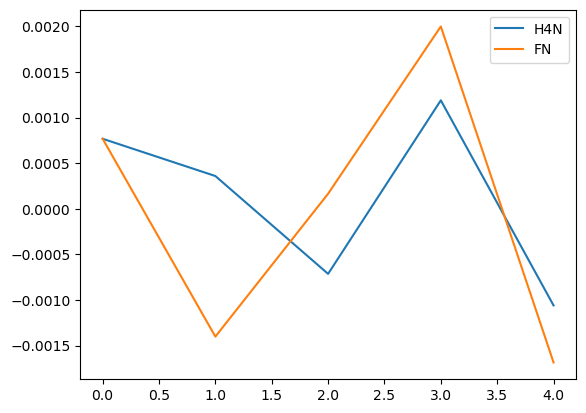

In [28]:
plt.plot(plot_df_h4n, label = 'H4N')
plt.plot(plot_df_fn, label = 'FN')
plt.legend()
plt.show()